Integrating sphere
==================

For some experiments it may be sufficient to perform light stimulation with a standard computer monitor, but where research calls for advanced control over the geometry of retinal stimulation, a bespoke setup is required. One solution is to use a Maxwellian view pupillometry system, where the light stimulus is focused onto an aperture positioned in front of the eye, or in the entrance plane of a pharmacologically dilated pupil, and the consensual pupil response is measured from the other eye. But this approach requires optical engineering and resources that may not be available in the average research setting. As an alternative, we developed a low-cost integrating sphere that provides a full-field, 'Ganzfeld', stimulus and precludes the need for optical engineering, pharmacological dilation of the pupil, and strict fixation control on behalf of the participant.

Construction
------------

We built the sphere from two 45 cm flanged acrylic half domes ([Project Plastics Ltd](https://www.projectplastics.co.uk/)), each coated on the inside surface with [Avian-B white reflectance coating](https://aviantechnologies.com/product/avian-b-white-reflectance-coating/) to scatter light homogenously. A 28 cm opening in one of the domes serves as a viewing port and an additional 7 cm (subtending ~9 degrees from the plane of the viewing port) opening opposite the viewing port was included to allow for secondary stimuli (e.g., a fixation target) or to allow for exclusion of the foveal macular pigment from stimulation. On the same half of the sphere as the viewing port, a 30 mm entry port for the light source was cut at an angle of 22.5 deg from the top, such that it could not be seen directly when looking straight ahead. The sphere and STLAB were stabilised on a wooden fixing plate making it suitable for placement on a desk. 


<img src="../img/setup.JPG" alt="Integrating sphere" title="Integrating sphere" width="500"/>

Calibration
-----------

To build a calibrated forward model of our STLAB-sphere rig that represents what an observer actually sees when looking into it, we collected measurements with an external spectrometer positioned at the plane of the viewing port. The `pyplr.calibrate` module streamlines this process with a `SpectraTuneLabSampler()` class, which is just a sub-class of `pyplr.stlab.SpectraTuneLab` with added sampling methods and support for an external spectrometer. Any spectrometer with a python interface can be integrated here with minimal effort, but we used an [Ocean Optics STS-VIS](https://www.oceaninsight.com/products/spectrometers/microspectrometer/sts-series/sts-vis/), supported by `pyplr.oceanops` and the [Seabreeze](https://pypi.org/project/seabreeze/) Python library. 

It would take a long time to sample every possible device setting, so we opted to sample the full range of intensities in steps of 63 for each LED. 

```Python
from pyplr.calibrate import SpectraTuneLabSampler
from pyplr.oceanops import OceanOptics

oo = OceanOptics.from_first_available()
d = SpectraTuneLabSampler(password='***************', external=oo)

# specify leds and intensities to sample
leds = [0,1,2,3,4,5,6,7,8,9]
intensities = [i for i in range(0, 4096, 65)]

# sample
d.sample(leds=leds, 
         intensities=intensities, 
         external=oo,
         randomise=True)
d.make_dfs(save_csv=True)
```

The above code instructs STLAB to cycle through all of the specified settings and obtain measurements with the on-board spectrometer and external spectrometer (if specified), and then finally to save the data to CSV format in the current working directory.

Calibrating the resulting OceanOptics data was an involved process complicated by the need to account for the effect of spectrometer PCB temperature and integration time on the raw data. Our pipeline is shown below, minus the code for fitting the data in MATLAB. 

In [3]:
import pandas as pd
from pyplr.oceanops import predict_dark_counts, calibrated_radiance

# Load Ocean Optics data
oo_spectra_fname = '../data/S2_oo_led_intensity_spectra.csv'
oo_info_fname = '../data/S2_oo_led_intensity_info.csv'
oo_spectra = pd.read_csv(
    oo_spectra_fname, index_col=['led','intensity'])
oo_spectra.reset_index(drop=True, inplace=True)
oo_info = pd.read_csv(oo_info_fname)

# Load a file with parameters accounting for the relationship 
# between temperature and integration time. This was created by
# sampling the dark spectrum across a range of temperatures 
# and times and fitting the data in MATLAB.
darkcal = pd.read_table(
    '../data/oo_dark_cal.txt', skiprows=2, index_col=False)

# Predict the dark spectrum for the temperatures and
# integration times of our measurements
oo_dark_counts = predict_dark_counts(oo_info, darkcal)

# Load some spectrometer constants
cal_per_wl = pd.read_csv(
    '../data/oo_calibration.csv', header=None)
sensor_area_cm2 = pd.read_csv(
    '../data/oo_sensorArea.csv', header=None)

# Calculate calibrated radiance
w_m2_nm = calibrated_radiance(
    oo_spectra, 
    oo_info, 
    oo_dark_counts,
    cal_per_wl, 
    sensor_area_cm2)

# Clean up
w_m2_nm['led'] = oo_info['led']
w_m2_nm['intensity'] = oo_info['intensity']
w_m2_nm.set_index(['led', 'intensity'], inplace=True)
w_m2_nm.sort_index(inplace=True)
w_m2_nm = w_m2_nm.interpolate(axis=1)
w_m2_nm.to_csv('../data/S2_corrected_oo_spectra.csv')
w_m2_nm

380       381       382       383       384       385  \
led intensity                                                               
0   0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    65         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    130        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    195        0.000026  0.000020  0.000023  0.000012  0.000033  0.000040   
    260        0.000147  0.000152  0.000158  0.000165  0.000155  0.000145   
...                 ...       ...       ...       ...       ...       ...   
9   3835       0.003778  0.004093  0.003488  0.003937  0.003176  0.003136   
    3900       0.003541  0.003839  0.003389  0.003721  0.003089  0.003009   
    3965       0.003653  0.003971  0.003476  0.004007  0.003401  0.003161   
    4030       0.003891  0.003956  0.003668  0.003874  0.003149  0.003184   
    4095       0.003615  0.004133  0.003597  0.004069  0.003316  0.003332   

                    386       387       388       389  ...       771  \
led intensity                                          ...             
0   0          0.000000  0.000000  0.000000  0.000000  ...  0.000000   
    65         0.000000  0.000000  0.000000  0.000000  ...  0.000000   
    130        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
    195        0.000030  0.000032  0.000035  0.000028  ...  0.000015   
    260        0.000154  0.000141  0.000171  0.000167  ...  0.000083   
...                 ...       ...       ...       ...  ...       ...   
9   3835       0.003321  0.002896  0.003240  0.003787  ...  0.002468   
    3900       0.003012  0.002801  0.003189  0.003692  ...  0.002366   
    3965       0.003371  0.002836  0.003298  0.003639  ...  0.002297   
    4030       0.003271  0.002737  0.003217  0.003631  ...  0.002531   
    4095       0.003100  0.003010  0.003414  0.003781  ...  0.002344   

                    772       773       774       775       776       777  \
led intensity                                                               
0   0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    65         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    130        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    195        0.000000  0.000008  0.000011  0.000000  0.000013  0.000012   
    260        0.000075  0.000087  0.000083  0.000072  0.000087  0.000085   
...                 ...       ...       ...       ...       ...       ...   
9   3835       0.002702  0.002610  0.002494  0.002934  0.002626  0.002619   
    3900       0.002733  0.002390  0.002299  0.002797  0.002622  0.002441   
    3965       0.002765  0.002593  0.002545  0.002785  0.002709  0.002760   
    4030       0.002757  0.002546  0.002377  0.002724  0.002598  0.002409   
    4095       0.002647  0.002569  0.002451  0.002913  0.002743  0.002612   

                    778       779       780  
led intensity                                
0   0          0.000013  0.000000  0.000000  
    65         0.000000  0.000000  0.000000  
    130        0.000000  0.000000  0.000000  
    195        0.000000  0.000017  0.000000  
    260        0.000008  0.000101  0.000082  
...                 ...       ...       ...  
9   3835       0.002212  0.002527  0.002909  
    3900       0.002099  0.002625  0.002919  
    3965       0.002129  0.002687  0.002693  
    4030       0.002036  0.002534  0.002836  
    4095       0.002170  0.002548  0.002757  

[640 rows x 401 columns]

We can now pass the calibrated spectrometer data to `pyplr.calibrate.CalibrationContext(...)`, which will use linear interpolation to create lookup tables that predict the spectral output for the full range of device settings, along with the alphaopic irradiances, lux and radiance values.

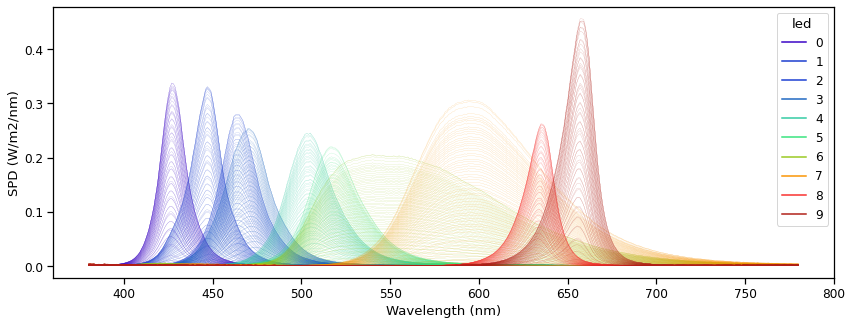

In [4]:
from pyplr.calibrate import CalibrationContext

cc = CalibrationContext(
    '../data/S2_corrected_oo_spectra.csv', binwidth=1)
fig = cc.plot_calibrated_spectra()

Of note, `CalibrationContext(...)` has a `.predict_spd(...)` method which we can use to predict the spectral output of STLABfrom a list of led-intensity values. Here we compare the predicted output to the actual measured output for 40 random device settings.

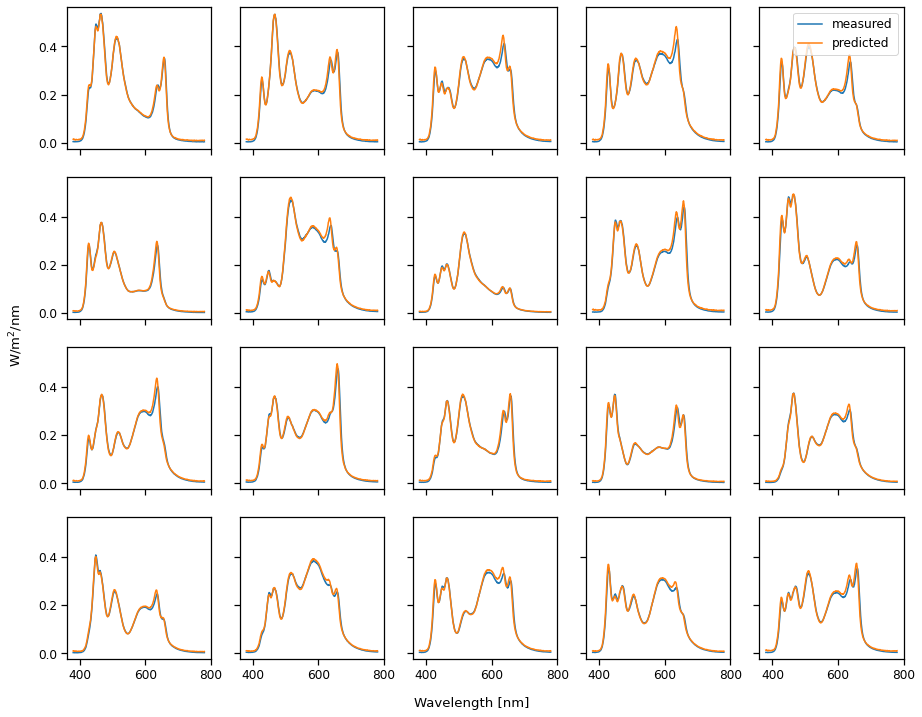

In [5]:
import ast
import matplotlib.pyplot as plt

# Load data from 40 random spectra
test_specs = pd.read_csv(
    '../data/S2_corrected_40_random_oo_spectra.csv')
test_spec_info = pd.read_csv(
    '../data/S2_oo_40_random_spectra_info.csv')

# Set up figure
fig, axs = plt.subplots(
    nrows=4, ncols=5, figsize=(15,12), sharey=True, sharex=True)
axs = [ax for sublist in axs for ax in sublist]

# Predict, measure and plot for 20 random inputs
for i, ax in enumerate(axs):
    pred = cc.predict_spd(ast.literal_eval(
        test_spec_info.loc[i,'intensities']))
    wls = pred.columns
    ax.plot(wls, test_specs.loc[i].to_numpy(), label='measured')
    ax.plot(wls, pred.to_numpy()[0], label='predicted')
    if i==4:
        ax.legend()
fig.text(0.5, 0.07, 'Wavelength [nm]', ha='center')
fig.text(
    0.07, 0.5, 'W/m$^2$/nm', va='center', rotation='vertical');

Safety
------

We evaluated the safety of our stimulation system in accordance with the [British Standards Document on the Photobiological Safety of Lamps and Lamp Systems (BS EN 62471)](https://landingpage.bsigroup.com/LandingPage/Undated?UPI=000000000030149289). Initial scoping measurements collected with a Photo Research SpectraScan PR-670 for all LEDs at 100% gave a luminance reading of 18000 cd/m$^2$. In particular, we addressed the following statements from the BS EN 62471:

**BS EN 62471: Section 4.1 (Annex ZB, page 40)**

> Detailed spectral data is required if the luminance of the source exceeds 10$^4$ cd/m$^-$$^2$

The maximum output of our source exceeded this specification so we obtained detailed spectral measurements.

**BS EN 62471: Section 4.3.3**

> To protect against retinal photochemical injury from chronic blue-light exposure, the integrated spectral radiance of the light source weighted against the blue-light hazard function, $B(\lambda)$, i.e., the blue light weighted radiance, LB, shall not exceed the levels defined by: 
>
> 𝐿 ∙𝑡= ∑700∑ 𝐿 (𝜆,𝑡)∙𝐵(𝜆)∙∆𝑡∙∆𝜆≤106 𝐽∙𝑚−2 ∙𝑠𝑟−1 (for𝑡≤104𝑠)
>
> 𝐿 = ∑700∑ 𝐿 ∙𝐵(𝜆)∙∆𝜆≤100𝑊∙𝑚−2 ∙𝑠𝑟−1 (for𝑡>104𝑠)
>
> Where:
>
> 𝐿𝜆(𝜆, 𝑡) is the spectral radiance in 𝑊 ∙ 𝑚−2 ∙ 𝑠𝑟−1 ∙ 𝑛𝑚−1 𝐵(𝜆) is the blue-light hazard weighting function
>
> ∆𝜆 is the bandwidth in nm
>
> 𝑡 is the exposure duration in seconds

Using the minimum radiance limit for the retinal blue light hazard exposure limit, given as 100 𝑊 ∙ 𝑚−2 ∙ 𝑠𝑟−1 for exposures of greater than 10000s, we can see that both sources are below this retinal blue light hazard exposure limit. These findings were confirmed by processing the data with the NPL EyeLight software.

**Section 4.2.1 (Annex ZB, page 40)**

> When the luminance of the source is adequately high (>10cd.m-2), and the exposure duration is greater the 0.25s, a 3mm pupil diameter (7mm2 area) was used to derive the exposure limit

Given that our sphere may be used in a dark room following a period of dark adaptation, pupil diameter will be greater than 3mm at the start of exposure. Typical experimental exposures will also be greater than 0.25s.

Pupil ratio (7)2 = 5.4 3

To take this into account we applied a pupil correction factor of 6, which reduces the retinal blue light hazard exposure limit to 16.6 𝑊 ∙ 𝑚−2 ∙ 𝑠𝑟−1.

In conclusion, when running the source at 100% and applying a safety factor to correct for the pupil size, our stimulation system is above the radiance retinal blue light hazard exposure limit value of 100 𝑊 ∙ 𝑚−2 ∙ 𝑠𝑟−1 for an exposure of 10000s.